### 3 Analysis - Plaque Density Distribution

A sliding window approach was applied on the whole slide images (WSIs) with the trained CNN model to generate confidence heatmaps. 

The WSIs were tiled into 1536 x 1536 images patches in the prepocessing steps. A sliding window approached was applied on evey image patch of a WSI. At each time, the CNN model took a 256x256 pixels region as input, forward propagated and generated a prediction score for cored plaque, diffuse plaque and CAA respectively. By systematically sliding the input region across the entire 1536 x 1536 image patch, the prediction scores were saved and ploted as prediction confidence heatmap for this patch. The heatmap for the WSI was obtained by doing this on all image patches of it.

Based on the heatmap prediction scores (saved as npy), we analyzed the plaque density distribution

In [1]:
import os, glob, datetime
from time import time

import numpy as np
import matplotlib
#matplotlib.use('PDF')   # for heatmap with original
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib qt
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from tqdm import tqdm
import copy

In [2]:
IMG_DIR  = 'data/outputs/norm_png/'
SAVE_DIR = 'data/outputs/thres_tissue_png/'

filenames = glob.glob(IMG_DIR + '*.png')
filenames = [filename.split('/')[-1] for filename in filenames]
filenames = [filename.split('.')[-2] for filename in filenames]
filenames.sort()
print(filenames)

['NA3777-02_AB', 'NA4077-02_AB', 'NA4092-02_AB', 'NA4107-02_AB', 'NA4160-02_AB', 'NA4195-02_AB', 'NA4256-02_AB', 'NA4299-02_AB', 'NA4391-02_AB', 'NA4450-02_AB', 'NA4463-02_AB', 'NA4471-02_AB', 'NA4553-02_AB', 'NA4626-02_AB', 'NA4672-02_AB', 'NA4675-02_AB', 'NA4691-02_AB', 'NA4695-02_AB']


In [3]:
# Load normalized original WSI and save thresholded Hematoxylin
from skimage.util import img_as_float

def color_deconv(rgb, conv_matrix):
    """RGB to stain color space conversion using color deconvolution.
    Original implementation in scikit-image 
    https://github.com/scikit-image/scikit-image/blob/master/skimage/color/colorconv.py#L1350
    
    Parameters
    ----------
    rgb : array_like
        The image in RGB format, in a 3-D array of shape ``(.., .., 3)``.
    conv_matrix: ndarray
        The stain separation matrix as described by G. Landini [1]_.
    Returns
    -------
    out : ndarray
        The image in stain color channel, in a 2-D array of shape
        ``(.., ..)``.
    """
    #rgb = img_as_float(rgb, force_copy=True)
    rgb = rgb.astype(dtype='float32')
    rgb += 2
    rgb = -np.log10(rgb, dtype='float32')
    out_shape = (rgb.shape[0], rgb.shape[1], 2)
    #rgb = np.reshape(rgb, (-1, 3)) @ (conv_matrix[:,0:2])  # 0:2 because only H&E channels are needed
    rgb = np.matmul(np.reshape(rgb, (-1, 3)), (conv_matrix[:,0:2]), dtype='float32')
    return np.reshape(rgb, out_shape)

# Scale [0,1] to [0,255]
def uint8scale(arr, _min=0, _max=1):
    return ((arr - _min) * 1/(_max - _min) * 255).astype('uint8')

# Scale arr to [new_min, new_max]
def scale_range(arr, new_min, new_max):
    return (arr - arr.min()) * (new_max - new_min) / (arr.max() - arr.min()) + new_min

# Scale arr to have new_mean and new_std
def scale_meanstd(arr, new_mean, new_std):
    return (arr - np.mean(arr)) / np.std(arr) * new_std + new_mean

# Apply contrast threshold using QuPath data
def apply_contrast_threshold(arr, thres_min, thres_max):
    arr[arr < thres_min] = thres_min
    arr[arr > thres_max] = thres_max
    return scale_range(arr, 0, 1)

# Apply contrast threshold using QuPath data
def apply_contrast_threshold_binary(arr, thres_min, thres_max):
    return np.where((arr < thres_min) | (arr > thres_max), 0.0, 1.0)

# To the right of maximum count, smaller than maximum by a factor of prop_high, larger than total pixel # by a factor of prop_low
# def hemato_thres(ys, prop_low = 0.0001, prop_high=0.05):
#     total = ys.shape[0]
#     unique, count = np.unique(ys, return_counts=True)
#     max_idx = np.argmax(count)
    
#     thres_low = total * prop_low
#     thres_high = count[max_idx] * prop_high
    
#     count_R = count[max_idx:]
#     idx_thres = np.asarray(np.where((count_R >= thres_low) & (count_R <= thres_high))).reshape(-1,) + max_idx
    
#     return apply_contrast_threshold(ys, unique[idx_thres[0]], unique[idx_thres[-1]])

def hemato_thres(ys, prop_low = 0.0005, prop_high=0.05):
    
#     %matplotlib notebook

    #total = ys.shape[0]
    unique, count = np.unique(ys, return_counts=True)
    max_idx = np.argmax(count)
    print("Max: ", count[max_idx], "at", unique[max_idx])
    
    ###
#     fig = plt.figure()
#     ax = fig.add_subplot(121, title='Original')
#     ax.plot(unique, count)
#     ax.set_xlim(unique[0], unique[-1])
    ###
    
    #thres_low = total * prop_low
    thres_high = count[max_idx] * prop_high
    
    count_R = count[max_idx:]
    #idx_thres = np.asarray(np.where((count_R >= thres_low) & (count_R <= thres_high))).reshape(-1,) + max_idx
    idx_thres = np.asarray(np.where((count_R > thres_high))).reshape(-1,) + max_idx
    #idx_thres = np.asarray(np.where((count_R < thres_high))).reshape(-1,) + max_idx
    
    #thres_ys = apply_contrast_threshold(ys.copy(), unique[idx_thres[0]], unique[idx_thres[-1]])
    #_return = apply_contrast_threshold_binary(ys, unique[idx_thres[0]], unique[idx_thres[-1]])
    
#     thres_ys = apply_contrast_threshold(ys.copy(), unique[idx_thres[-1]+1], unique[-1])
    _return = apply_contrast_threshold_binary(ys, unique[idx_thres[-1]+1], unique[-1])
    
    ###
#     ax = fig.add_subplot(122, title='Hemato Thres')
#     unique, count = np.unique(thres_ys,return_counts=True)
#     ax.plot(unique, count)
#     ax.set_xlim(unique[0], unique[-1])
    ###
    return _return


t = tqdm(total=len(filenames))
for i, filename in enumerate(filenames):
#     if not (filename == 'NA4450-02_AB'):
#         continue
    
    img = np.array(Image.open(IMG_DIR+filename+'.png'))
    assert(img.dtype == 'uint8')
    height, width, _ = img.shape
    
    t.set_description_str("Image " + filename + ', ' + str(img.shape))
    t.refresh()
    t.write("", end=' ')

    # Corresponding stain matrix
    stain_mat = np.array([[0.624, 0.662, 0.415], [0.469, 0.612, 0.637], [0.616, -0.743, 0.261]]) # ref: NA5002_2
    stain_mat = np.linalg.inv(stain_mat)

    # Separate stains
    # i=0: Hematoxylin, i=1: Eosin, i=2: Residual
    mask_img = color_deconv(img, stain_mat)
    del img
    
    # Thresholding Hematoxylin
    norm_img = hemato_thres(mask_img[:,:,0].ravel()).reshape(height, width)
    norm_img = np.asarray(uint8scale(norm_img), dtype='uint8')

    # Convert numpy array into PIL image and save to local
    # Divide the WSI into regular slices to avoid PIL buffer overflow
    slice_size = 30000
    iters = np.uint8(np.ceil([height / slice_size, width / slice_size]))

    mask_img = Image.new('L', (width, height))
    for row in range(iters[0]):
        for col in range(iters[1]):
            # Get start and end pixel location
            start_r, start_c = row * slice_size, col * slice_size
            end_r, end_c = min(height, start_r + slice_size), min(width, start_c + slice_size)

            # Paste the slice mask to image mask
            mask_slice = Image.fromarray(norm_img[start_r:end_r, start_c:end_c], 'L')
            mask_img.paste(mask_slice, (start_c, start_r))
    # Save masked image
    mask_img.save(SAVE_DIR+filename+'_Hemato_thres.png')
    del norm_img, mask_slice, mask_img
    
    t.update()
t.close()

Image NA3777-02_AB, (47616, 55296, 3):   0%|          | 0/18 [01:14<?, ?it/s]

 Max:  235515480 at -1.4634409


Image NA4077-02_AB, (47616, 73728, 3):   6%|▌         | 1/18 [08:49<2:00:57, 426.91s/it]

 Max:  157540155 at -1.4929314


Image NA4092-02_AB, (46080, 66048, 3):  11%|█         | 2/18 [17:36<2:02:46, 460.41s/it]

 Max:  258635830 at -1.5040579


Image NA4107-02_AB, (36864, 69120, 3):  17%|█▋        | 3/18 [27:22<2:05:55, 503.67s/it]

 Max:  382568220 at -1.4982014


Image NA4160-02_AB, (43008, 59904, 3):  22%|██▏       | 4/18 [35:20<1:55:45, 496.09s/it]

 Max:  115965763 at -1.5052247


Image NA4195-02_AB, (39936, 56832, 3):  28%|██▊       | 5/18 [42:52<1:44:56, 484.36s/it]

 Max:  190104888 at -1.5305872


Image NA4256-02_AB, (47616, 62976, 3):  33%|███▎      | 6/18 [50:27<1:32:59, 464.95s/it]

 Max:  156965654 at -1.5040579


Image NA4299-02_AB, (44544, 58368, 3):  39%|███▉      | 7/18 [1:00:45<1:34:33, 515.78s/it]

 Max:  114419030 at -1.5305872


Image NA4391-02_AB, (47616, 50688, 3):  44%|████▍     | 8/18 [1:08:47<1:24:56, 509.63s/it]

 Max:  197038277 at -1.5352192


Image NA4450-02_AB, (47616, 58368, 3):  50%|█████     | 9/18 [1:15:55<1:12:29, 483.28s/it]

 Max:  410472770 at -1.5095057


Image NA4463-02_AB, (46080, 55296, 3):  56%|█████▌    | 10/18 [1:24:35<1:06:00, 495.07s/it]

 Max:  188721611 at -1.5474582


Image NA4471-02_AB, (36864, 69120, 3):  61%|██████    | 11/18 [1:32:14<56:30, 484.34s/it]  

 Max:  175591984 at -1.4920726


Image NA4553-02_AB, (47616, 69120, 3):  67%|██████▋   | 12/18 [1:40:10<47:51, 478.56s/it]

 Max:  638070458 at -1.5414557


Image NA4626-02_AB, (43008, 49152, 3):  72%|███████▏  | 13/18 [1:48:30<40:58, 491.76s/it]

 Max:  121806653 at -1.5692123


Image NA4672-02_AB, (36864, 50688, 3):  78%|███████▊  | 14/18 [1:55:14<31:13, 468.46s/it]

 Max:  214180336 at -1.5216582


Image NA4675-02_AB, (46080, 55296, 3):  83%|████████▎ | 15/18 [2:01:04<21:20, 426.69s/it]

 Max:  276667686 at -1.5304255


Image NA4691-02_AB, (41472, 55296, 3):  89%|████████▉ | 16/18 [2:08:29<14:27, 433.63s/it]

 Max:  195866521 at -1.512187


Image NA4695-02_AB, (43008, 56832, 3):  94%|█████████▍| 17/18 [2:16:03<07:19, 439.92s/it]

 Max:  187683044 at -1.487917


Image NA4695-02_AB, (43008, 56832, 3): 100%|██████████| 18/18 [2:22:16<00:00, 474.23s/it]


In [ ]:
# Load normalized original WSI and save color deconv result
from skimage.util import img_as_float

def color_deconv(rgb, conv_matrix):
    """RGB to stain color space conversion using color deconvolution.
    Original implementation in scikit-image 
    https://github.com/scikit-image/scikit-image/blob/master/skimage/color/colorconv.py#L1350
    
    Parameters
    ----------
    rgb : array_like
        The image in RGB format, in a 3-D array of shape ``(.., .., 3)``.
    conv_matrix: ndarray
        The stain separation matrix as described by G. Landini [1]_.
    Returns
    -------
    out : ndarray
        The image in stain color channel, in a 2-D array of shape
        ``(.., ..)``.
    """
    #rgb = img_as_float(rgb, force_copy=True)
    rgb = rgb.astype(dtype='float32')
    rgb += 2
    rgb = -np.log10(rgb, dtype='float32')
    out_shape = (rgb.shape[0], rgb.shape[1], 2)
    #rgb = np.reshape(rgb, (-1, 3)) @ (conv_matrix[:,0:2])  # 0:2 because only H&E channels are needed
    rgb = np.matmul(np.reshape(rgb, (-1, 3)), (conv_matrix[:,0:2]), dtype='float32')
    return np.reshape(rgb, out_shape)

# Scale [0,1] to [0,255]
def uint8scale(arr, _min=0, _max=1):
    return ((arr - _min) * 1/(_max - _min) * 255).astype('uint8')

# Scale arr to [new_min, new_max]
def scale_range(arr, new_min, new_max):
    return (arr - arr.min()) * (new_max - new_min) / (arr.max() - arr.min()) + new_min

# Scale arr to have new_mean and new_std
def scale_meanstd(arr, new_mean, new_std):
    return (arr - np.mean(arr)) / np.std(arr) * new_std + new_mean

# Apply contrast threshold using QuPath data
def apply_contrast_threshold(arr, thres_min, thres_max):
    arr[arr < thres_min] = thres_min
    arr[arr > thres_max] = thres_max
    return scale_range(arr, 0, 1)

t = tqdm(total=len(filenames))
for i, filename in enumerate(filenames):
    #if i != 0:
    #   continue
    
    img = np.array(Image.open(IMG_DIR+filename+'.png'))
    assert(img.dtype == 'uint8')
    height, width, _ = img.shape
    
    t.set_description_str("Image " + str(i) + ': ' + str(img.shape))
    t.refresh()
    t.write("", end=' ')

    # Corresponding stain matrix
    stain_mat = np.array([[0.624, 0.662, 0.415], [0.469, 0.612, 0.637], [0.616, -0.743, 0.261]]) # ref: NA5002_2
    stain_mat = np.linalg.inv(stain_mat)

    # Separate stains
    # i=0: Hematoxylin, i=1: Eosin, i=2: Residual
    mask_img = color_deconv(img, stain_mat)
    del img
    
    norm_img = []
    for i in range(2):
        # Scale using mean and standard deviation
        mask_img[:,:,i] = scale_range(mask_img[:,:,i], 0, 1)

        # Convert into uint8
        norm_img.append(np.asarray(uint8scale(mask_img[:,:,i]), dtype='uint8'))
    del mask_img

    # Convert numpy array into PIL image and save to local
    # Divide the WSI into regular slices to avoid PIL buffer overflow
    slice_size = 30000
    iters = np.uint8(np.ceil([height / slice_size, width / slice_size]))

    for i in range(2):
        mask_img = Image.new('L', (width, height))
        for row in range(iters[0]):
            for col in range(iters[1]):
                # Get start and end pixel location
                start_r, start_c = row * slice_size, col * slice_size
                end_r, end_c = min(height, start_r + slice_size), min(width, start_c + slice_size)

                # Paste the slice mask to image mask
                mask_slice = Image.fromarray(norm_img[i][start_r:end_r, start_c:end_c], 'L')
                mask_img.paste(mask_slice, (start_c, start_r))
        # Save masked image
        if i == 0:
            mask_img.save(SAVE_DIR+filename+'_Hemato.png')
        elif i == 1:
            mask_img.save(SAVE_DIR+filename+'_Eosin.png')
        del mask_slice, mask_img
    
    t.update()
t.close()

### Separate stains

In [8]:
# Separate stains
#from skimage.color import separate_stains       # Too much memory burden, separate computation tasks
from skimage.util import img_as_float
from tempfile import mkdtemp
import shutil

def color_deconv(rgb, conv_matrix):
    """RGB to stain color space conversion using color deconvolution.
    Original implementation in scikit-image 
    https://github.com/scikit-image/scikit-image/blob/master/skimage/color/colorconv.py#L1350
    
    Parameters
    ----------
    rgb : array_like
        The image in RGB format, in a 3-D array of shape ``(.., .., 3)``.
    conv_matrix: ndarray
        The stain separation matrix as described by G. Landini [1]_.
    Returns
    -------
    out : ndarray
        The image in stain color channel, in a 2-D array of shape
        ``(.., ..)``.
    """
    #rgb = img_as_float(rgb, force_copy=True)
    rgb = rgb.astype(dtype='float32')
    rgb += 2
    rgb = -np.log10(rgb, dtype='float32')
    out_shape = (rgb.shape[0], rgb.shape[1], 2)
    #rgb = np.reshape(rgb, (-1, 3)) @ (conv_matrix[:,0:2])  # 0:2 because only H&E channels are needed
    rgb = np.matmul(np.reshape(rgb, (-1, 3)), (conv_matrix[:,0:2]), dtype='float32')
    return np.reshape(rgb, out_shape)

# Scale [0,1] to [0,255]
def uint8scale(arr, _min=0, _max=1):
    return ((arr - _min) * 1/(_max - _min) * 255).astype('uint8')

# Scale arr to [new_min, new_max]
def scale_range(arr, new_min, new_max):
    return (arr - arr.min()) * (new_max - new_min) / (arr.max() - arr.min()) + new_min

# Scale arr to have new_mean and new_std
def scale_meanstd(arr, new_mean, new_std):
    return (arr - np.mean(arr)) / np.std(arr) * new_std + new_mean

# Apply contrast threshold using QuPath data
def apply_contrast_threshold(arr, thres_min, thres_max):
    arr[arr < thres_min] = thres_min
    arr[arr > thres_max] = thres_max
    return scale_range(arr, 0, 1)

# def outliers_prop_quantity(ys, prop_low = 0.0001, prop_high = 0.05):
#     total = ys.shape[0]
#     thres_low = total * prop_low
#     thres_high = total * prop_high
#     _, idx, count = np.unique(ys, return_inverse=True,return_counts=True)
#     print(count[count.argsort()[-10:][::-1]])
#     mask = np.zeros_like(ys)
#     thres_idx = np.where((count>=thres_low) & (count<=thres_high))[0]
#     mask[np.isin(idx,thres_idx)] = 1.0
#     return mask

def outliers_prop_quantity(ys, prop_low = 0.0001, prop_high = 0.05):
    total = ys.shape[0]
    thres_low = total * prop_low
    thres_high = total * prop_high
    _, idx, count = np.unique(ys, return_inverse=True,return_counts=True)
    print(count[count.argsort()[-10:][::-1]])
    thres_idx = np.where((count>=thres_low) & (count<=thres_high))[0]
    scaled = ys[np.isin(idx,thres_idx)]
    return apply_contrast_threshold(ys, scaled.min(), scaled.max())

# Create a memmap numpy array on disk for float64 WSI
# dirpath = mkdtemp()
# fp = os.path.join(dirpath, 'arr.dat')
# print(dirpath)

startT = time()

# Divide the WSI into regular slices to avoid insufficient memory
# Cannot divide WSI into slices due to contrast threshold and scale_meanstd
# slice_size = 10000
rgb_img = np.array(Image.open('data/outputs/norm_png/NA4195-02_AB.png'))
height, width, _ = rgb_img.shape
print(rgb_img.shape)

# Corresponding stain matrix
#stain_mat = np.array([[0.572, 0.589, 0.572], [0.281, 0.514, 0.811], [0.488, -0.804, 0.341]]) # NA3077
stain_mat = np.array([[0.624, 0.662, 0.415], [0.469, 0.612, 0.637], [0.616, -0.743, 0.261]]) # ref: NA5002_2
stain_mat = np.linalg.inv(stain_mat)

# Corresponding scale and contrast threshold constants
consts = []
consts.append({'mean':0.037, 'std':0.12, 'thres_min':-0.045568, 'thres_max':1.051931})
consts.append({'mean':0.091, 'std':0.106, 'thres_min':0.01, 'thres_max':0.3})

# t = tqdm(total=2)
# for i in range(2):

# Separate stains
# i=0: Hematoxylin, i=1: Eosin, i=2: Residual
print('Load Image: %s' % (time()-startT))
mask_img = color_deconv(rgb_img, stain_mat)
del rgb_img
print('Color Deconv: %s' % (time()-startT))

# norm_img = []
# for i in range(2):
    
#     fig = plt.figure(figsize=(12,8))
#     ax = fig.add_subplot(121, title='Original')
#     ax.hist(mask_img[:,:,i].ravel(), bins=256)
#     ax.set_xlim(mask_img[:,:,i].min(), mask_img[:,:,i].max())
    
#     # Remove outlier based on proportion
#     mask_img[:,:,i] = outliers_prop_quantity(mask_img[:,:,i].ravel()).reshape(height, width)
    
#     ax = fig.add_subplot(122, title='After')
#     ax.hist(mask_img[:,:,i].ravel(), bins=256)
#     ax.set_xlim(mask_img[:,:,i].min(), mask_img[:,:,i].max())
    
#     # Scale using mean and standard deviation
#     #mask_img[:,:,i] = scale_meanstd(mask_img[:,:,i], consts[i]['mean'], consts[i]['std'])

#     # Apply contrast threshold
#     #mask_img[:,:,i] = apply_contrast_threshold(mask_img[:,:,i], consts[i]['thres_min'], consts[i]['thres_max'])

#     # Convert into uint8
#     norm_img.append(np.asarray(uint8scale(mask_img[:,:,i]), dtype='uint8'))
# del mask_img

# # Convert numpy array into PIL image and save to local
# # Divide the WSI into regular slices to avoid PIL buffer overflow
# slice_size = 30000
# iters = np.uint8(np.ceil([height / slice_size, width / slice_size]))

# for i in range(2):
#     mask_img = Image.new('L', (width, height))
#     for row in range(iters[0]):
#         for col in range(iters[1]):
#             # Get start and end pixel location
#             start_r, start_c = row * slice_size, col * slice_size
#             end_r, end_c = min(height, start_r + slice_size), min(width, start_c + slice_size)

#             # Paste the slice mask to image mask
#             mask_slice = Image.fromarray(norm_img[i][start_r:end_r, start_c:end_c], 'L')
#             mask_img.paste(mask_slice, (start_c, start_r))
#     # Save masked image
#     if i == 0:
#         mask_img.save('data/outputs/norm_png/NA4195-02_AB_Hemato_4.png')
#     elif i == 1:
#         mask_img.save('data/outputs/norm_png/NA4195-02_AB_Eosin_4.png')
#     del mask_slice, mask_img
    
# print('Total: %s' % (time()-startT))
# plt.show()
# #     t.update()
# # t.close()

# # Remove memmap files
# # shutil.rmtree(dirpath)

(39936, 56832, 3)
Load Image: 66.44727396965027
Color Deconv: 177.37883973121643


In [5]:
# dev
# To the right of maximum count, smaller than maximum by a factor of prop_high, larger than total pixel # by a factor of prop_low
def hemato_thres(ys, prop_low = 0.0001, prop_high=0.05):
    total = ys.shape[0]
    unique, count = np.unique(ys, return_counts=True)
    max_idx = np.argmax(count)
    
    thres_low = total * prop_low
    thres_high = count[max_idx] * prop_high
    
    count_R = count[max_idx:]
    idx_thres = np.asarray(np.where((count_R >= thres_low) & (count_R <= thres_high))).reshape(-1,) + max_idx
    
    return apply_contrast_threshold(ys, unique[idx_thres[0]], unique[idx_thres[-1]])

norm_img = hemato_thres(mask_img[:,:,0].ravel()).reshape(height, width)
norm_img = np.asarray(uint8scale(norm_img), dtype='uint8')

# Convert numpy array into PIL image and save to local
# Divide the WSI into regular slices to avoid PIL buffer overflow
slice_size = 30000
iters = np.uint8(np.ceil([height / slice_size, width / slice_size]))
mask_img2 = Image.new('L', (width, height))
for row in range(iters[0]):
    for col in range(iters[1]):
        # Get start and end pixel location
        start_r, start_c = row * slice_size, col * slice_size
        end_r, end_c = min(height, start_r + slice_size), min(width, start_c + slice_size)

        # Paste the slice mask to image mask
        mask_slice = Image.fromarray(norm_img[start_r:end_r, start_c:end_c], 'L')
        mask_img2.paste(mask_slice, (start_c, start_r))
# Save masked image
mask_img2.save('data/outputs/norm_png/NA4195-02_AB_Hemato_thres.png')
del norm_img, mask_slice, mask_img2

In [ ]:
from scipy.signal import find_peaks

def outliers_prop_quantity(ys, prop_low = 0.0001, prop_high = 0.05):
    total = ys.shape[0]
    thres_low = total * prop_low
    thres_high = total * prop_high
    _, idx, count = np.unique(ys, return_inverse=True,return_counts=True)
    #print(count[count.argsort()[-10:][::-1]])
    result = ys[np.isin(idx,np.where((count>=thres_low) & (count<=thres_high))[0])]
    return result

# To the right of maximum count, smaller than maximum by a factor of prop
def hemato_thres(ys, prop_low = 0.0001, prop_high=0.05):
#     currentDT = datetime.datetime.now(); print(str(currentDT)); startT = time()
#     unique, idx, count = np.unique(ys, return_inverse=True, return_counts=True)
#     print("Unique: %s" % (time()-startT)); startT = time()
    
#     max_idx = np.argmax(count)
#     print("Unique: %s" % (time()-startT)); startT = time()
    
#     y_thres = count[max_idx] * prop
#     idx_thres = np.asarray(np.where(count[max_idx:]<=y_thres)).reshape((-1,)) + max_idx
#     print("idx_thres: %s" % (time()-startT)); startT = time()
    
#     return ys[np.isin(idx,idx_thres)]
    total = ys.shape[0]
    unique, count = np.unique(ys, return_counts=True)
    max_idx = np.argmax(count)
    
    thres_low = total * prop_low
    thres_high = count[max_idx] * prop_high
    
    count_R = count[max_idx:]
    idx_thres = np.asarray(np.where((count_R >= thres_low) & (count_R <= thres_high))).reshape(-1,) + max_idx
    
    return apply_contrast_threshold(ys, unique[idx_thres[0]], unique[idx_thres[-1]])

# hist, bin_edges = np.histogram(mask_img[:,:,0].ravel(), bins=10000)
# bin_center = (bin_edges[1:] + bin_edges[:-1]) / 2
%matplotlib notebook

currentDT = datetime.datetime.now(); print(str(currentDT)); startT = time()

fig = plt.figure()

ax = fig.add_subplot(121, title='Original')
unique, count = np.unique(mask_img[:,:,0].ravel(),return_counts=True)
# peaks, _ = find_peaks(count, height=0.25e7, prominence=1e2)
# print(peaks)
# #ax.hist(ihc_hdx[:,:,0].ravel(), bins=256)
ax.plot(unique, count)
# ax.plot(unique[peaks], count[peaks] , "x",markersize=20)
ax.set_xlim(mask_img[:,:,0].min(), mask_img[:,:,0].max())
del unique, count
print("Original: %s" % (time()-startT)); startT = time()

ax = fig.add_subplot(122, title='Hemato Thres')
mask_outlier = hemato_thres(mask_img[:,:,0].ravel())
unique, count = np.unique(mask_outlier,return_counts=True)
ax.plot(unique, count)
ax.set_xlim(mask_outlier.min(), mask_outlier.max())
print("Hemato Thres: %s" % (time()-startT))



# ax = fig.add_subplot(122, title='Remove Outliers')
# mask_outlier = outliers_prop_quantity(mask_img[:,:,0].ravel(), 0.0001, 1)
# unique, count = np.unique(mask_outlier,return_counts=True)
# ax.plot(unique, count)
# ax.set_xlim(mask_outlier.min(), mask_outlier.max())

#ax = fig.add_subplot(133, title='Peak-Valley-Peak')



# ax.plot(bin_center, hist)
# peaks, _ = find_peaks(hist, height=0.25e7, prominence=1e5)
# print(peaks)
# ax.plot(bin_center[peaks], hist[peaks] , "x",markersize=20)
# ax.set_xlim(mask_img[:,:,1].min(), mask_img[:,:,1].max())



2019-10-02 07:29:02.454225


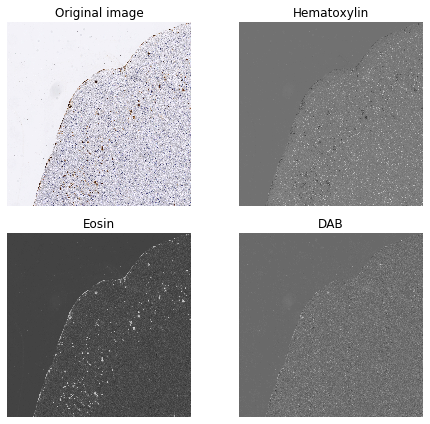

In [3]:
# Separate stains (dev)
from skimage.color import separate_stains
#stain_mat = np.array([[0.572, 0.589, 0.572], [0.281, 0.514, 0.811], [0.488, -0.804, 0.341]]) # NA3077
stain_mat = np.array([[0.624, 0.662, 0.415], [0.469, 0.612, 0.637], [0.616, -0.743, 0.261]]) # ref: NA5002_2
rgb_img = np.array(Image.open('data/outputs/norm_png/NA4195-02_AB.png'))

ihc_hdx = separate_stains(rgb_img[0:10000, 0:10000, :], np.linalg.inv(stain_mat))
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(rgb_img[0:10000, 0:10000, :])
ax[0].set_title("Original image")

ax[1].imshow(ihc_hdx[:, :, 0], cmap='gray')
ax[1].set_title("Hematoxylin")

ax[2].imshow(ihc_hdx[:, :, 1], cmap='gray')
ax[2].set_title("Eosin")

ax[3].imshow(ihc_hdx[:, :, 2], cmap='gray')
ax[3].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

In [43]:
# Separate stains (dev)
consts = []
consts.append({'mean':0.037, 'std':0.12, 'thres_min':-0.045568, 'thres_max':1.051931})
consts.append({'mean':0.091, 'std':0.106, 'thres_min':0.01, 'thres_max':0.3})

In [12]:
from scipy.signal import find_peaks

hist, bin_edges = np.histogram(ihc_hdx[:,:,0].ravel(), bins=256)
bin_center = (bin_edges[1:] + bin_edges[:-1]) / 2
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, title='Peak-Valley-Peak')
ax.plot(bin_center, hist)

peaks, _ = find_peaks(hist, height=0.25e7, prominence=1e5)
print(peaks)
ax.plot(bin_center[peaks], hist[peaks] , "x",markersize=20)
ax.set_xlim(ihc_hdx[:,:,0].min(), ihc_hdx[:,:,0].max())


[113 123]


(-0.5249813983534513, -0.014467965081054027)

<IPython.core.display.Javascript object>


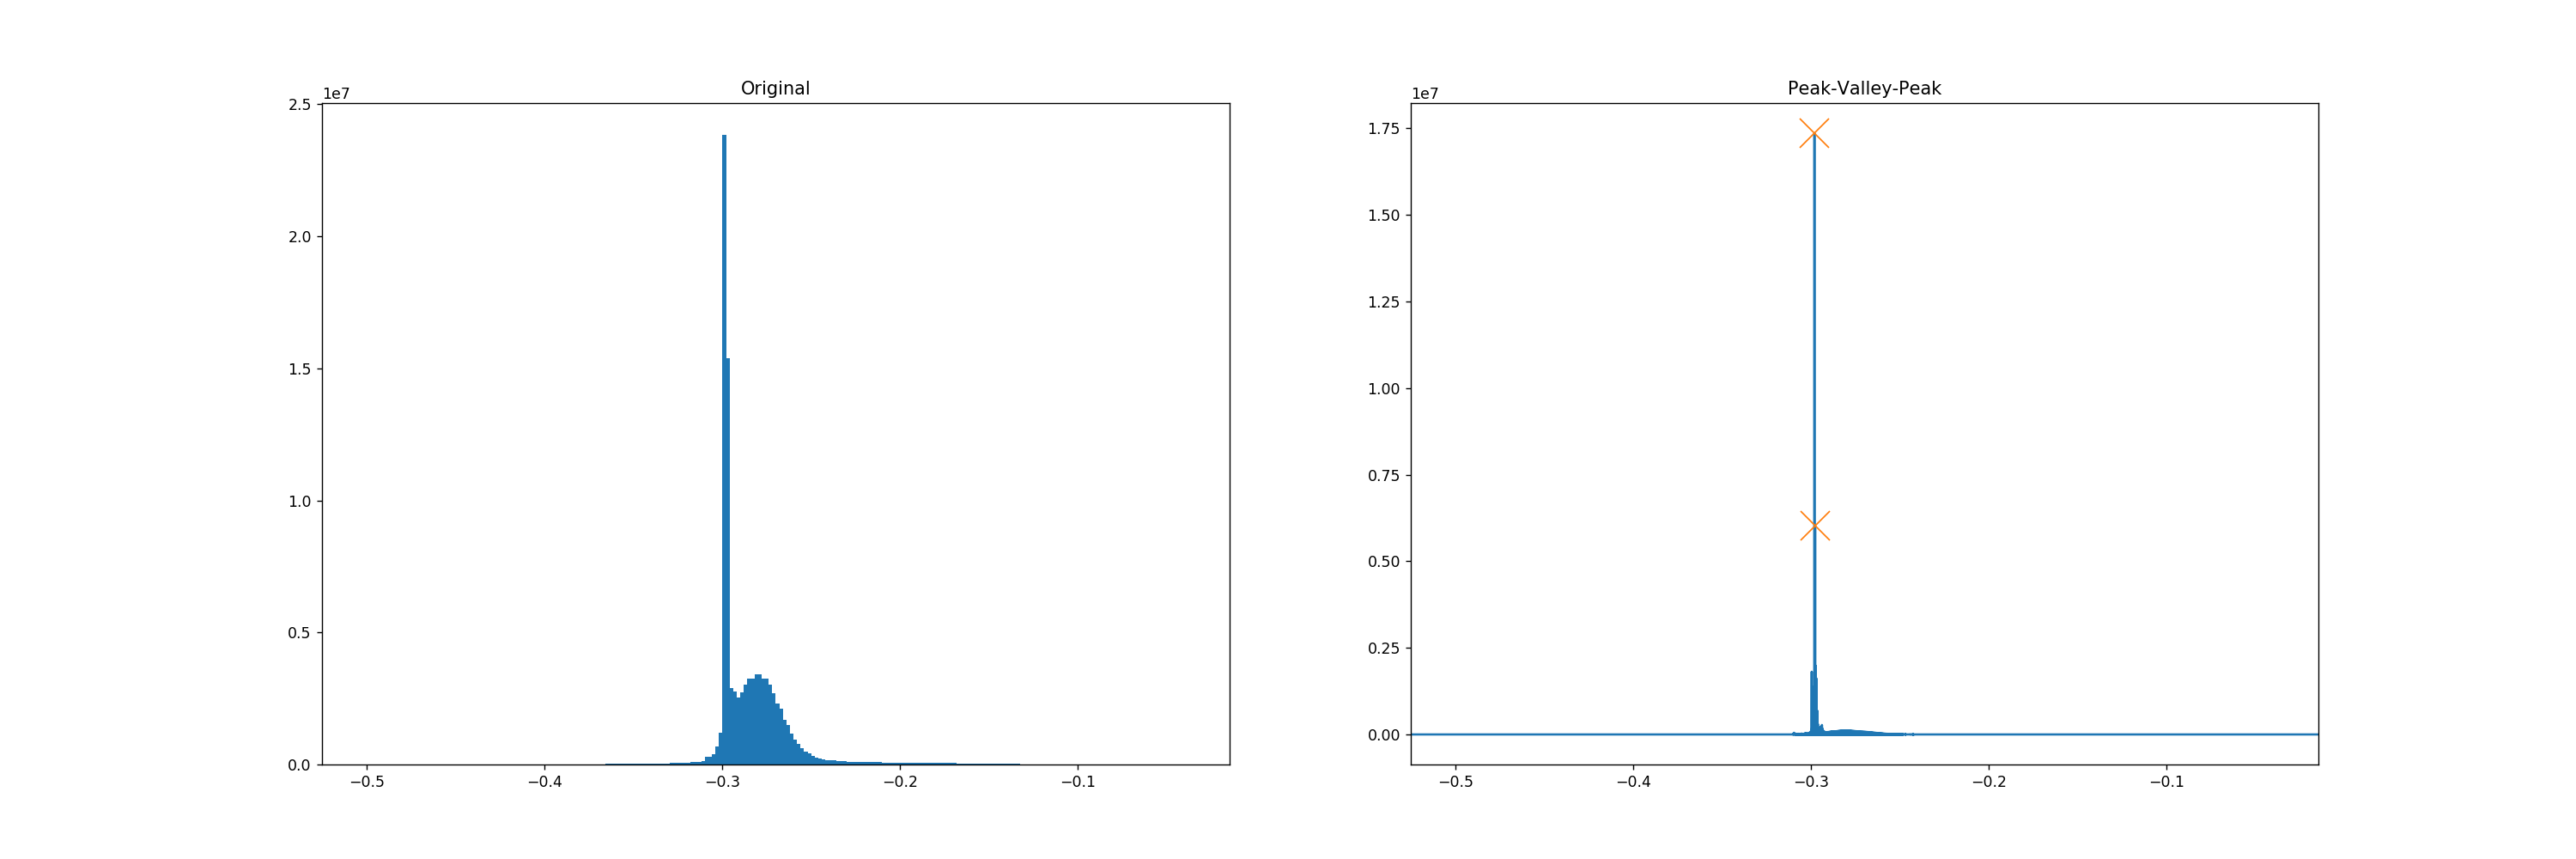

<IPython.core.display.Javascript object>


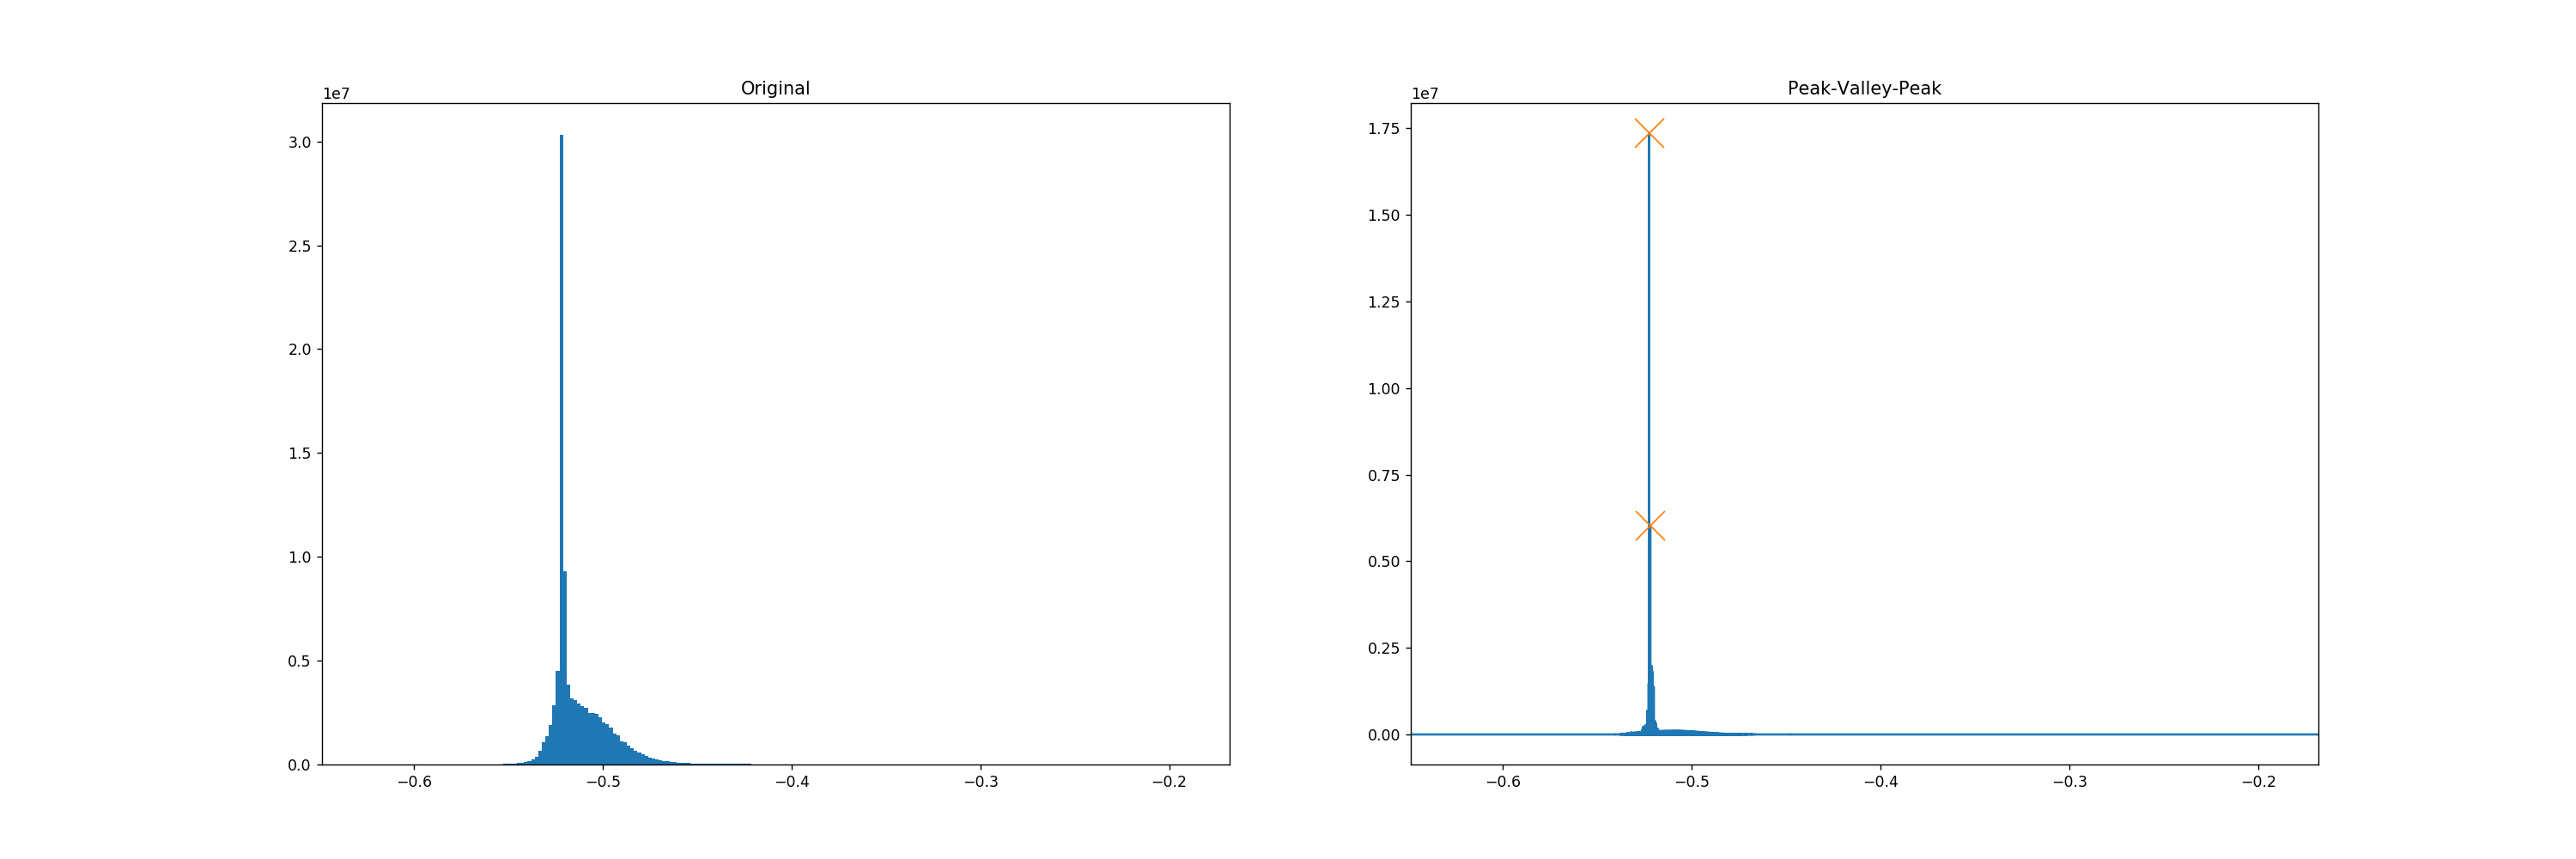

2019-09-29 21:47:47.938995
[81525 81884]
Outlier 0: 5.081860780715942
[42192 42813]
Outlier 1: 5.172244548797607


In [8]:
# Separate stains (dev)
def scale_range(arr, new_min, new_max):
    return (arr - arr.min()) * (new_max - new_min) / (arr.max() - arr.min()) + new_min

def scale_meanstd(arr, new_mean, new_std):
    return (arr - np.mean(arr)) / np.std(arr) * new_std + new_mean

def apply_contrast_threshold(arr, thres_min, thres_max):
    arr[arr < thres_min] = thres_min
    arr[arr > thres_max] = thres_max
    return scale_range(arr, 0, 1)

# Use outlier removal
def outliers_z_score(ys):
    threshold = 2
    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return ys[np.where(np.abs(z_scores) < threshold)]

def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr)
    upper_bound = quartile_3 + (iqr)
    return ys[np.where((ys < upper_bound) & (ys > lower_bound))]

def outliers_prop_quantity(ys, prop_low = 0.0001, prop_high = 0.05):
    total = ys.shape[0]
    thres_low = total * prop_low
    thres_high = total * prop_high
    _, idx, count = np.unique(ys, return_inverse=True,return_counts=True)
    print(count[count.argsort()[-10:][::-1]])
    result = ys[np.isin(idx,np.where((count>=thres_low) & (count<=thres_high))[0])]
    return result

fig1 = plt.figure(figsize=(24,8))
ax = fig1.add_subplot(121, title='Original')
ax.hist(ihc_hdx[:,:,0].ravel(), bins=256)
ax.set_xlim(ihc_hdx[:,:,0].min(), ihc_hdx[:,:,0].max())

fig2 = plt.figure(figsize=(24,8))
ax = fig2.add_subplot(121, title='Original')
ax.hist(ihc_hdx[:,:,1].ravel(), bins=256)
ax.set_xlim(ihc_hdx[:,:,1].min(), ihc_hdx[:,:,1].max())

currentDT = datetime.datetime.now(); print(str(currentDT)); totalT = 0.0; startT = time()

# ax = fig1.add_subplot(152, title='Z Outlier')
# ihc_hdx_0_z = outliers_z_score(ihc_hdx[:,:,0].ravel())
# ax.hist(ihc_hdx_0_z, bins=256)
# ax.set_xlim(ihc_hdx_0_z.min(), ihc_hdx_0_z.max())
# print("Outlier 0: %s" % (time()-startT)); startT = time()

# ax = fig2.add_subplot(152, title='Z Outlier')
# ihc_hdx_1_z = outliers_z_score(ihc_hdx[:,:,1].ravel())
# ax.hist(ihc_hdx_1_z, bins=256)
# ax.set_xlim(ihc_hdx_1_z.min(), ihc_hdx_1_z.max())
# print("Outlier 1: %s" % (time()-startT)); startT = time()

# ax = fig1.add_subplot(153, title='IQR Outlier')
# ihc_hdx_0_iqr = outliers_iqr(ihc_hdx[:,:,0].ravel())
# ax.hist(ihc_hdx_0_iqr, bins=256)
# ax.set_xlim(ihc_hdx_0_iqr.min(), ihc_hdx_0_iqr.max())
# print("Outlier 0: %s" % (time()-startT)); startT = time()

# ax = fig2.add_subplot(153, title='IQR Outlier')
# ihc_hdx_1_iqr = outliers_iqr(ihc_hdx[:,:,1].ravel())
# ax.hist(ihc_hdx_1_iqr, bins=256)
# ax.set_xlim(ihc_hdx_1_iqr.min(), ihc_hdx_1_iqr.max())
# print("Outlier 1: %s" % (time()-startT)); startT = time()

# ax = fig1.add_subplot(154, title='Removed Outlier')
# ihc_hdx_0_removed = outliers_prop_quantity(ihc_hdx[:,:,0].ravel())
# ax.hist(ihc_hdx_0_removed, bins=256)
# ax.set_xlim(ihc_hdx_0_removed.min(), ihc_hdx_0_removed.max())
# print("Outlier 0: %s" % (time()-startT)); startT = time()

# ax = fig2.add_subplot(154, title='Removed Outlier')
# ihc_hdx_1_removed = outliers_prop_quantity(ihc_hdx[:,:,1].ravel())
# ax.hist(ihc_hdx_1_removed, bins=256)
# ax.set_xlim(ihc_hdx_1_removed.min(), ihc_hdx_1_removed.max())
# print("Outlier 1: %s" % (time()-startT)); startT = time()

from scipy.signal import find_peaks

ax = fig1.add_subplot(122, title='Peak-Valley-Peak')
unique, count = np.unique(ihc_hdx[:,:,0].ravel(),return_counts=True)
peaks, _ = find_peaks(count, height=0.25e7, prominence=1e2)
print(peaks)
#ax.hist(ihc_hdx[:,:,0].ravel(), bins=256)
ax.plot(unique, count)
ax.plot(unique[peaks], count[peaks] , "x",markersize=20)
ax.set_xlim(ihc_hdx[:,:,0].min(), ihc_hdx[:,:,0].max())
print("Outlier 0: %s" % (time()-startT)); startT = time()

ax = fig2.add_subplot(122, title='Peak-Valley-Peak')
unique, count = np.unique(ihc_hdx[:,:,1].ravel(),return_counts=True)
peaks, _ = find_peaks(count, height=0.25e7, prominence=1e2)
print(peaks)
#ax.hist(ihc_hdx[:,:,1].ravel(), bins=256)
ax.plot(unique, count)
ax.plot(unique[peaks], count[peaks] , "x",markersize=20)
ax.set_xlim(ihc_hdx[:,:,1].min(), ihc_hdx[:,:,1].max())
print("Outlier 1: %s" % (time()-startT)); startT = time()

# new_ihc_hdx_0_scale = scale_meanstd(ihc_hdx[:,:,0], consts[0]['mean'], consts[0]['std'])
# new_ihc_hdx_1_scale = scale_meanstd(ihc_hdx[:,:,1], consts[1]['mean'], consts[1]['std'])

# ax = fig1.add_subplot(132, title='Scaled')
# ax.hist(new_ihc_hdx_0_scale.ravel(), bins=256)
# ax.axvline(x=consts[0]['thres_min'], color='r', linestyle='dashed', linewidth=2)
# ax.axvline(x=consts[0]['thres_max'], color='r', linestyle='dashed', linewidth=2)
# ax.set_xlim(new_ihc_hdx_0_scale.min(), new_ihc_hdx_0_scale.max())

# ax = fig2.add_subplot(132, title='Scaled')
# ax.hist(new_ihc_hdx_1_scale.ravel(), bins=256)
# ax.axvline(x=consts[1]['thres_min'], color='r', linestyle='dashed', linewidth=2)
# ax.axvline(x=consts[1]['thres_max'], color='r', linestyle='dashed', linewidth=2)
# ax.set_xlim(new_ihc_hdx_1_scale.min(), new_ihc_hdx_1_scale.max())

# new_ihc_hdx_0 = apply_contrast_threshold(new_ihc_hdx_0_scale, consts[0]['thres_min'], consts[0]['thres_max'])
# new_ihc_hdx_1 = apply_contrast_threshold(new_ihc_hdx_1_scale, consts[1]['thres_min'], consts[1]['thres_max'])

# ax = fig1.add_subplot(133, title='Thresholded')
# ax.hist(new_ihc_hdx_0.ravel(), bins=256)
# ax.set_xlim(new_ihc_hdx_0.min(), new_ihc_hdx_0.max())

# ax = fig2.add_subplot(133, title='Thresholded')
# ax.hist(new_ihc_hdx_1.ravel(), bins=256)
# ax.set_xlim(new_ihc_hdx_1.min(), new_ihc_hdx_1.max())

# fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True)
# ax = axes.ravel()

# ax[0].imshow(rgb_img[0:10000, 0:10000, :])
# ax[0].set_title("Original image")

# ax[1].imshow(new_ihc_hdx_0, cmap='gray')
# ax[1].set_title("Hematoxylin")

# ax[2].imshow(new_ihc_hdx_1, cmap='gray')
# ax[2].set_title("Eosin")

# ax[3].imshow(ihc_hdx[:, :, 2], cmap='gray')
# ax[3].set_title("Residual")

# for a in ax.ravel():
#     a.axis('off')

fig.tight_layout()
plt.show()

### Superpixel

In [ ]:
# Superpixel
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import datetime

# Scale [0,1] to [0,255]
def uint8scale(arr, _min=0, _max=1):
    return ((arr - _min) * 1/(_max - _min) * 255).astype('uint8')

img = np.array(Image.open('data/outputs/norm_png/NA3777-02_AB_Eosin.png'))
# Binary Thresholding
img = np.where(img < 15, 0, 255).astype('uint8')
height, width = img.shape
print(img.shape)

img = img_as_float(img)

# # Memory (128+32) overflow using float64 after 5 minutes
# currentDT = datetime.datetime.now(); print(str(currentDT)); startT = time()
# segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
# print("Felzenszwalb: %s" % (time()-startT)); currentDT = datetime.datetime.now(); print(str(currentDT))
# print("Felzenszwalb number of segments: {}".format(len(np.unique(segments_fz))))
# fig = plt.figure(figsize=(15, 15))
# fig.imshow(mark_boundaries(img, segments_fz))
# fig.set_title("Felzenszwalbs's method")
# plt.show()
# del segments_fz

# Max memory 123+16 using float64. 255 segments. Run time: 1324 seconds = 22 minutes
# 40000: 1445s   80000: 1436s
currentDT = datetime.datetime.now(); print(str(currentDT)); startT = time()
segments_slic = slic(img, n_segments=60000, compactness=0.01, slic_zero=True)
np.save('segments_slic_60000', segments_slic)
print("SLIC: %s" % (time()-startT))
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))

del img
img = np.array(Image.open('data/outputs/norm_png/NA3777-02_AB_Eosin.png'))
# Binary Thresholding
img = np.where(img < 15, 0, 255).astype('uint8')
print('Loaded')
mark_img = mark_boundaries(img, segments_slic, outline_color=(1,1,0), mode='thick')
print('Marked')
del segments_slic, img
norm_img = uint8scale(mark_img)
print('Normalized')
del mark_img

save_img = Image.fromarray(norm_img, 'RGB')
save_img.save('NA3777-02_AB_Eosin_SLICOT15 60000, 0.01.png')

# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, title='SLIC')
# ax.imshow(norm_img)
# fig.savefig('NA3777-02_AB_Eosin_SLIC.pdf', dpi=fig.dpi, bbox_inches='tight')
# plt.close(fig)

# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, title='SLIC')
# ax.imshow(norm_img)
# plt.show()

print('Saved')
print("Total: %s" % (time()-startT))

# # Require RGB image
# currentDT = datetime.datetime.now(); print(str(currentDT)); startT = time()
# segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
# print("Quickshift: %s" % (time()-startT))
# print('Quickshift number of segments: {}'.format(len(np.unique(segments_quick))))
# fig, ax= plt.subplots(1, 1, figsize=(15, 15))
# ax.imshow(mark_boundaries(img, segments_quick))
# ax.set_title('Quickshift')
# plt.show()
# del segments_quick

# # Max memory 128+32 using float64. 255 segments. Run time: 9935 seconds = 165 minutes
# currentDT = datetime.datetime.now(); print(str(currentDT)); startT = time()
# gradient = sobel(rgb2gray(img))
# segments_watershed = watershed(gradient, markers=250, compactness=0.001)
# print("Watershed: %s" % (time()-startT))
# print('Watershed number of segments: {}'.format(len(np.unique(segments_watershed))))
# fig, ax= plt.subplots(1, 1, figsize=(15, 15))
# ax.imshow(mark_boundaries(img, segments_watershed))
# ax.set_title('Compact watershed')
# plt.show()
# del segments_watershed

# for a in ax.ravel():
#     a.set_axis_off()

# plt.tight_layout()
# plt.show()

(47616, 55296)
2019-09-18 06:32:53.595383


In [3]:
# Superpixel
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import slic
from skimage.util import img_as_float
import datetime

# Scale [0,1] to [0,255]
def uint8scale(arr, _min=0, _max=1):
    return ((arr - _min) * 1/(_max - _min) * 255).astype('uint8')

img = np.array(Image.open('data/outputs/norm_png/NA3777-02_AB_Eosin.png'))
# Binary Thresholding
img = np.where(img < 15, 0, 255).astype('uint8')
height, width = img.shape
print(img.shape)

img = img_as_float(img)

# Max memory 123+16 using float64. 255 segments. Run time: 1324 seconds = 22 minutes
currentDT = datetime.datetime.now(); print(str(currentDT)); startT = time()
segments_slic = slic(img, n_segments=20000, compactness=0.01, slic_zero=True)
print("SLIC: %s" % (time()-startT))
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))

del img
img = np.array(Image.open('data/outputs/norm_png/NA3777-02_AB_Eosin.png'))
# Binary Thresholding
img = np.where(img < 15, 0, 255).astype('uint8')

(47616, 55296)
2019-09-04 23:13:04.559699
SLIC: 1350.5294225215912
SLIC number of segments: 19679


In [4]:
np.save('segments_slic_20000', segments_slic)

In [3]:
# Save superpixel with average intensity
from skimage.measure import regionprops
segments_slic = np.load('segments_slic_80000.npy')
img = np.array(Image.open('data/outputs/norm_png/NA3777-02_AB_Eosin.png'))
# Binary Thresholding
img = np.where(img < 15, 0, 255).astype('uint8')
height, width = img.shape

mask_img = np.zeros_like(img, dtype='uint8')
for region in regionprops(segments_slic, img):
    mask_img.flat[np.ravel_multi_index(region.coords.transpose(), mask_img.shape)] = region.mean_intensity

# Convert numpy array into PIL image and save to local
# Divide the WSI into regular slices to avoid PIL buffer overflow
slice_size = 30000
iters = np.uint8(np.ceil([height / slice_size, width / slice_size]))

save_img = Image.new('L', (width, height))
for row in range(iters[0]):
    for col in range(iters[1]):
        # Get start and end pixel location
        start_r, start_c = row * slice_size, col * slice_size
        end_r, end_c = min(height, start_r + slice_size), min(width, start_c + slice_size)

        # Paste the slice mask to image mask
        save_slice = Image.fromarray(mask_img[start_r:end_r, start_c:end_c], 'L')
        save_img.paste(save_slice, (start_c, start_r))
# Save masked image
save_img.save('NA3777-02_AB_Eosin_SLIC_80000_meanintensity.png')

In [3]:
segments_slic = np.load('segments_slic_20000.npy')

In [4]:
img = np.array(Image.open('data/outputs/norm_png/NA3777-02_AB_Eosin.png'))
# Binary Thresholding
img = np.where(img < 15, 0, 255).astype('uint8')
height, width = img.shape

In [5]:
from skimage.measure import regionprops
intensity = []
for region in regionprops(segments_slic, img):
    intensity.append(region.mean_intensity)

In [9]:
from skimage.measure import regionprops
intensity = []
mask_img = np.zeros_like(img, dtype='uint8')
for region in regionprops(segments_slic, img):
    intensity.append(region.mean_intensity)
    if region.mean_intensity >= 50:
        mask_img.flat[np.ravel_multi_index(region.coords.transpose(), mask_img.shape)] = 255

# mask_img = Image.fromarray(mask_img, 'L')
# mask_img.save('NA3777-02_AB_Eosin_SLIC_meanintensityMSK.png')

# Convert numpy array into PIL image and save to local
# Divide the WSI into regular slices to avoid PIL buffer overflow
slice_size = 30000
iters = np.uint8(np.ceil([height / slice_size, width / slice_size]))

save_img = Image.new('L', (width, height))
for row in range(iters[0]):
    for col in range(iters[1]):
        # Get start and end pixel location
        start_r, start_c = row * slice_size, col * slice_size
        end_r, end_c = min(height, start_r + slice_size), min(width, start_c + slice_size)

        # Paste the slice mask to image mask
        save_slice = Image.fromarray(mask_img[start_r:end_r, start_c:end_c], 'L')
        save_img.paste(save_slice, (start_c, start_r))
# Save masked image
save_img.save('NA3777-02_AB_Eosin_SLIC_20000_meanintensityMSK.png')

19678


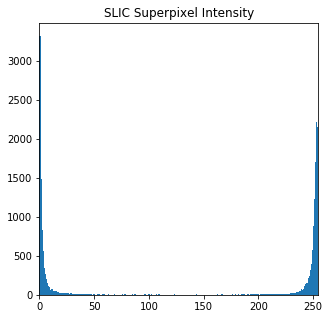

In [6]:
from skimage.filters import threshold_otsu

print(len(intensity))

#val = threshold_otsu(intensity)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, title='SLIC Superpixel Intensity')
ax.hist(intensity, bins=256)
ax.set_xlim(0, 255)
#ax.axvline(val, color='k', ls='--')
plt.show()

In [ ]:
#segments_slic = np.load('segments_slic.npy')
from skimage.measure import regionprops
intensity = []
mask_img = np.zeros_like(img, dtype='uint8')
for region in regionprops(segments_slic, img):
    intensity.append(region.mean_intensity)
    if region.mean_intensity >= 50:
        mask_img.flat[np.ravel_multi_index(region.coords.transpose(), mask_img.shape)] = 255

In [ ]:
from skimage.measure import regionprops
intensity = []
mask_img = np.zeros_like(img, dtype='uint8')
for region in regionprops(segments_slic, img):
    intensity.append(region.mean_intensity)
    if region.mean_intensity >= 50:
        mask_img.flat[np.ravel_multi_index(region.coords.transpose(), mask_img.shape)] = 255

### Edge Detection

In [4]:
import datetime
from skimage.filters import roberts, sobel
from skimage.feature import canny
img = np.array(Image.open('data/outputs/norm_png/NA3777-02_AB_Eosin.png'))
# Binary Thresholding
img = np.where(img < 15, 0, 255).astype('uint8')
height, width = img.shape

currentDT = datetime.datetime.now(); print(str(currentDT)); startT = time()
edge_rob = roberts(img)
print("Roberts: %s" % (time()-startT))

currentDT = datetime.datetime.now(); print(str(currentDT)); startT = time()
edge_sobel = sobel(img)
print("Sobel: %s" % (time()-startT))

# currentDT = datetime.datetime.now(); print(str(currentDT)); startT = time()
# edge_canny = canny(img)
# print("Canny: %s" % (time()-startT))

# Convert numpy array into PIL image and save to local
# Divide the WSI into regular slices to avoid PIL buffer overflow
slice_size = 30000
iters = np.uint8(np.ceil([height / slice_size, width / slice_size]))

edge_rob_img = Image.new('L', (width, height))
edge_sobel_img = Image.new('L', (width, height))
# edge_canny_img = Image.new('L', (width, height))

for row in range(iters[0]):
    for col in range(iters[1]):
        # Get start and end pixel location
        start_r, start_c = row * slice_size, col * slice_size
        end_r, end_c = min(height, start_r + slice_size), min(width, start_c + slice_size)

        # Paste the slice mask to image mask
        save_slice = Image.fromarray(edge_rob[start_r:end_r, start_c:end_c], 'L')
        edge_rob_img.paste(save_slice, (start_c, start_r))
        
        # Paste the slice mask to image mask
        save_slice = Image.fromarray(edge_sobel[start_r:end_r, start_c:end_c], 'L')
        edge_sobel_img.paste(save_slice, (start_c, start_r))
        
#         # Paste the slice mask to image mask
#         save_slice = Image.fromarray(edge_canny[start_r:end_r, start_c:end_c], 'L')
#         edge_canny_img.paste(save_slice, (start_c, start_r))
# Save masked image
edge_rob_img.save('NA3777-02_AB_Eosin_rob_edge.png')
edge_sobel_img.save('NA3777-02_AB_Eosin_sobel_edge.png')
#edge_canny_img.save('NA3777-02_AB_Eosin_canny_edge.png')

2019-09-03 22:40:59.216254
Roberts: 71.1693696975708
2019-09-03 22:42:10.385897
Sobel: 83.45647859573364


### Process first image in HSV colorspace

In [3]:
# Process first image in HSV colorspace
from skimage.color import rgb2hsv

# Scale [0,1] to [0,255]
def uint8scale(arr, _min=0, _max=1):
    return ((arr - _min) * 1/(_max - _min) * 255).astype('uint8')

# Divide the WSI into regular slices to avoid insufficient memory
slice_size = 30000
rgb_img = np.array(Image.open('data/outputs/norm_png/NA3777-02_AB.png'))
height, width, _ = rgb_img.shape
#iters = np.int64(np.ceil([height / slice_size, width / slice_size]))
iters = np.uint8(np.ceil([height / slice_size, width / slice_size]))
print(rgb_img.shape)

# Create a binary mask as output
#mask_img = Image.fromarray(np.zeros(rgb_img.shape[0:2], dtype=np.uint8), 'L')
mask_img = Image.new('L', (width, height))
t = tqdm(total=iters[0] * iters[1])
for row in range(iters[0]):
    for col in range(iters[1]):
        # Get start and end pixel location
        start_r, start_c = row * slice_size, col * slice_size
        end_r, end_c = min(height, start_r + slice_size), min(width, start_c + slice_size)
        
        # Convert the slice of image to HSV colorspace
        # hsv_img[:,:,0] = H, hsv_img[:,:,1] = S, hsv_img[:,:,2] = V
        hsv_slice = rgb2hsv(rgb_img[start_r:end_r, start_c:end_c, :])
        nor_slice = uint8scale(hsv_slice)
        
        # Create a mask for this slice
        mask_slice = np.zeros(nor_slice.shape[0:2], dtype=np.uint8)
        
        # S channel <= 15
        mask_slice[nor_slice[:,:,1] <= 15] = 255
        
        # H channel [0,140] U [190,255]
        mask_slice[(nor_slice[:,:,0] <= 140) & (nor_slice[:,:,0] >= 190)] = 255
        
        # Paste the slice mask to image mask
        mask_slice = Image.fromarray(mask_slice, 'L')
        mask_img.paste(mask_slice, (start_c, start_r))

        t.update()
t.close()
mask_img.save('data/outputs/norm_png/NA3777-02_AB_MSK.png')

(47616, 55296, 3)


100%|██████████| 4/4 [10:16<00:00, 155.17s/it]


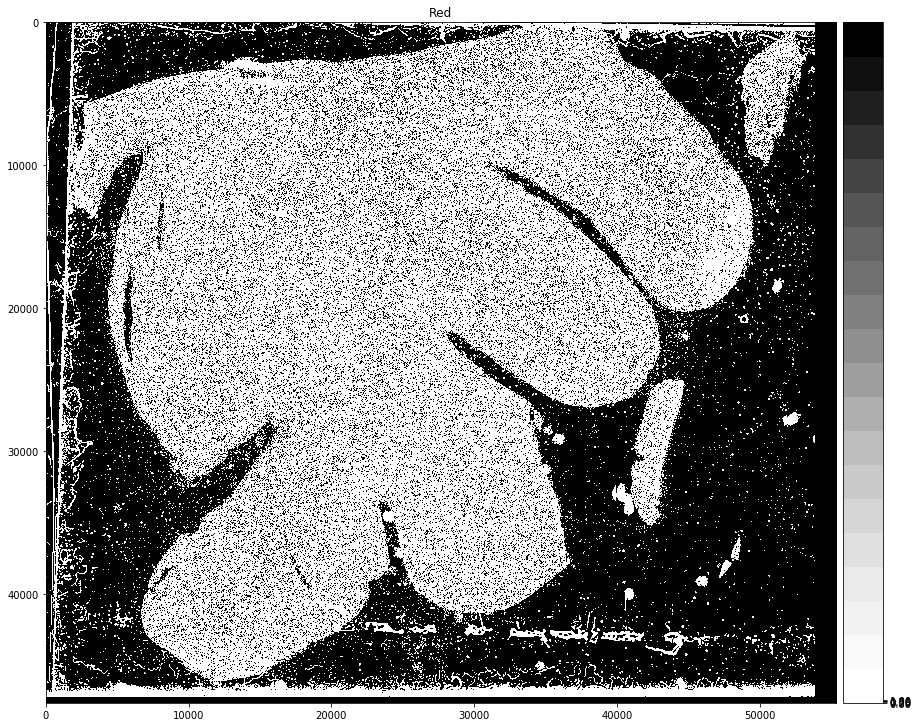

In [9]:
# Process first image in HSV colorspace (dev)
red = img[:,:,0]
mask_r = np.full(red.shape, 255, dtype=np.uint8)
mask_r[(red > 73) & (red < 231)] = 0

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, title='Red')
im = plt.imshow(mask_r, cmap=plt.cm.get_cmap('Greys', 20), vmin=0, vmax=255)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
plt.show()

### Clustering Algorithm (dev)

In [3]:
# Clustering Algorithm (dev)
# Process first image mask
mask_img = np.array(Image.open('data/outputs/norm_png/NA3777-02_AB_MSK.png'))
print(mask_img.shape)


(47616, 55296)


In [4]:
# Clustering Algorithm (dev)
from sklearn.cluster import Birch, MiniBatchKMeans
X = np.column_stack(np.where(mask_img == 255)) # tuple needs to be reversed
#model = Birch(threshold=10, n_clusters=None,compute_labels=True)
model = MiniBatchKMeans(random_state=0)
t = time()
model.fit(X)
time_ = time() - t
print('Time: %0.2f' % time_)
#model.predict(X)

Time: 2196.89


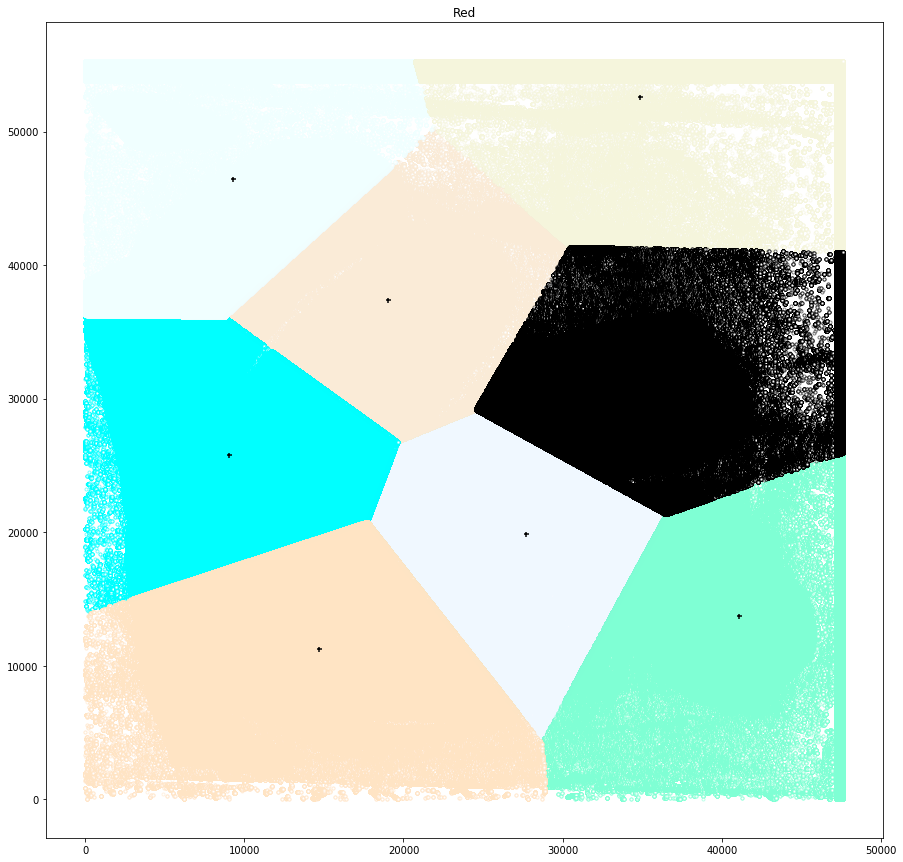

In [5]:
# Clustering Algorithm (dev)
# Plot MiniBatchKMeans result
from itertools import cycle
import matplotlib.colors as colors

colors_ = cycle(colors.cnames.keys())
mbk_means_labels_unique = np.unique(model.labels_)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, title='Red')
for this_centroid, k, col in zip(model.cluster_centers_,
                                 range(8), colors_):
    mask = model.labels_ == k
    ax.scatter(X[mask, 0], X[mask, 1], marker='.',
               c='w', edgecolor=col, alpha=0.5)
    ax.scatter(this_centroid[0], this_centroid[1], marker='+',
               c='k', s=25)

In [6]:
# Clustering Algorithm (dev)
from sklearn.cluster import Birch, MiniBatchKMeans
X = np.column_stack(np.where(mask_img == 255))
model = Birch(threshold=10, n_clusters=None,compute_labels=True)
#model = MiniBatchKMeans(random_state=0)
t = time()
model.fit(X)
time_ = time() - t
print('Time: %0.2f' % time_)
#model.predict(X)

MemoryError: 

In [ ]:
# Clustering Algorithm (dev)
# Plot result
import matplotlib.colors as colors

colors_ = cycle(colors.cnames.keys())
labels = birch_model.labels_
centroids = birch_model.subcluster_centers_
n_clusters = np.unique(labels).size
print("n_clusters : %d" % n_clusters)

fig = plt.figure()
ax = fig.add_subplot(111, title='Red')
for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
    mask = labels == k
    ax.scatter(X[mask, 0], X[mask, 1],
               c='w', edgecolor=col, marker='.', alpha=0.5)
    if birch_model.n_clusters is None:
        ax.scatter(this_centroid[0], this_centroid[1], marker='+',
                   c='k', s=25)